In [31]:
import pandas as pd
import duckdb as ddb
from urllib.parse import urlparse

In [32]:
# Function to extract the domain (e.g., www.usnews.com)
def extract_domain(url):
    domain = urlparse(url).netloc
    return domain

In [33]:
# Function to extract the necessary data from DataFrame
def extract_info(df):
    df.submission_date = pd.to_datetime(df.submission_date)
    df.comment_date = pd.to_datetime(df.comment_date)

    submissions_per_author = ddb.sql(
        "SELECT submission_author, COUNT(DISTINCT submission_title) AS submission_count FROM df GROUP BY submission_author ORDER BY submission_count DESC"
    )
    comments_per_comment_author = ddb.sql(
        "SELECT comment_author, COUNT(DISTINCT comment_text) AS comments_count FROM df GROUP BY comment_author ORDER BY comments_count DESC"
    )
    submission_urls_count = ddb.sql(
        "SELECT submission_url, COUNT(submission_url) AS submission_count FROM (SELECT DISTINCT submission_title, submission_url FROM df) GROUP BY submission_url ORDER BY submission_count DESC"
    )
    submission_urls_count_per_author = ddb.sql(
        "SELECT submission_author, submission_url, COUNT(submission_url) AS count FROM (SELECT DISTINCT submission_author, submission_date, submission_title, submission_url FROM df) GROUP BY submission_author, submission_url ORDER BY count DESC"
    )
    submissions_author_commenter = ddb.sql(
        "SELECT DISTINCT submission_author, submission_title, comment_text, submission_url FROM df WHERE submission_author = comment_author"
    )
    author_commenter_comments_count = ddb.sql(
        "SELECT submission_author, COUNT(comment_text) AS comments_count FROM submissions_author_commenter GROUP BY submission_author ORDER BY comments_count DESC"
    )
    top_submissions = ddb.sql(
        "SELECT DISTINCT submission_score, submission_upvote_ratio, submission_author, submission_url, submission_title FROM df ORDER BY submission_score DESC"
    )
    comments_per_hour = ddb.sql(
        "SELECT DATE_TRUNC('hour', comment_date) AS date, COUNT(comment_text) AS comments_count FROM df GROUP BY date ORDER BY date"
    )
    submissions_per_hour = ddb.sql(
        "SELECT DATE_TRUNC('hour', submission_date) AS date, COUNT(DISTINCT submission_title) AS submissions_count FROM df GROUP BY date ORDER BY date"
    )

    return (
        submissions_per_author,
        comments_per_comment_author,
        submission_urls_count,
        submission_urls_count_per_author,
        submissions_author_commenter,
        author_commenter_comments_count,
        top_submissions,
        comments_per_hour,
        submissions_per_hour,
    )

## Extract data for analysis

In [34]:
df = pd.read_csv("csvs/hot/politics/politics_hot_2025_03_17.csv")

df.submission_url = df.submission_url.apply(extract_domain)
(
    submissions_per_author,
    comments_per_comment_author,
    submission_urls_count,
    submission_urls_count_per_author,
    submissions_author_commenter,
    author_commenter_comments_count,
    top_submissions,
    comments_per_hour,
    submissions_per_hour,
) = extract_info(df)

df.sample(1)

,submission_date,submission_score,submission_upvote_ratio,submission_title,submission_selftext,submission_author,comment_date,comment_score,comment_author,comment_text,comment_is_submitter,submission_permalink,submission_url
8159,2025-03-16 20:58:30,1044,0.92,Elon Musk Backs Push To Impeach Judge Who Bloc...,NaN,huffpost,2025-03-16 21:52:02,2,Purusha120,Incredible how fast they’re running over the j...,False,/r/politics/comments/1jcvkj7/elon_musk_backs_p...,www.huffpost.com


In [35]:
top_submissions.df()

,submission_score,submission_upvote_ratio,submission_author,submission_url,submission_title
0,42479,0.94,Murky-Site7468,www.newsweek.com,Over 16K sign Democrat petition against Chuck ...
1,37686,0.90,Schiffy94,www.independent.co.uk,"Milwaukee mother deported to Laos, a country s..."
2,27346,0.93,sabedo,www.newsweek.com,"Republicans push to make ""Trump Derangement Sy..."
3,26413,0.98,thatnerdmatt,www.sfgate.com,"'Today, we celebrate': Judge says National Par..."
4,20850,0.95,dheber,newrepublic.com,Trump Celebrates After Killing Anti-Money-Laun...
...,...,...,...,...,...
142,12,0.88,theipaper,inews.co.uk,Trump's judge-defying immigration crackdown is...
143,12,0.88,Just_Sayin_Hey,www.wsj.com,Trump Administration Deports Alleged Gang Memb...
144,10,1.00,fasterwonder,www.ft.com,The Democrats must make a choice.
145,9,0.77,Street_Anon,nationalpost.com,‘It’s really terrible': What is Trump's plan t...


## Visualize data

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

### URLs with the highest number of posts

Text(0.5, 1.0, 'URLs with the highest number of posts')

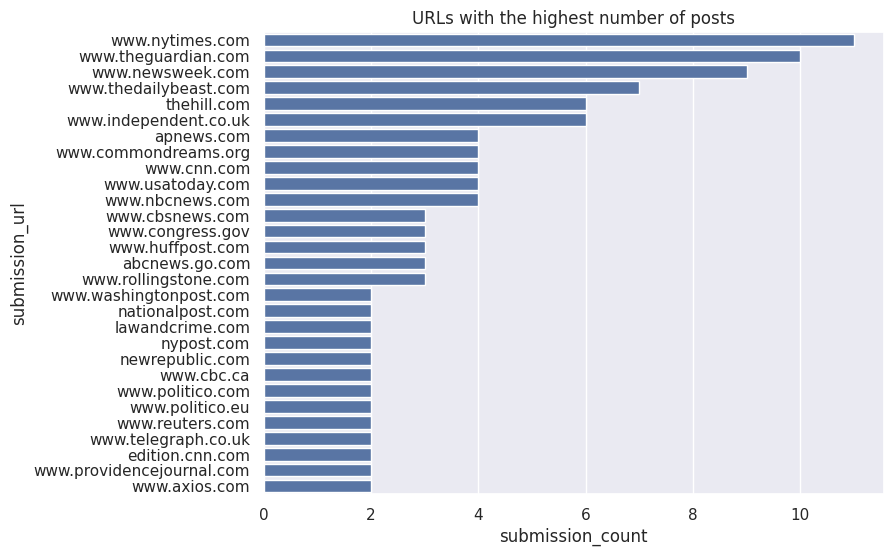

In [37]:
dbdf = ddb.sql("select * from submission_urls_count where submission_count > 1").df()
dbdf = dbdf.set_index("submission_url")
plt.figure(figsize=(8, 6))
sns.barplot(y=dbdf.index, x=dbdf.submission_count).set_title(
    "URLs with the highest number of posts"
)

In [25]:
dbdf = ddb.sql(
    "select submission_title, date_trunc('hour', comment_date) AS date, count(comment_text) as comments_count from df group by date, submission_title order by submission_title, date"
).df()
dbdf.date = pd.to_datetime(dbdf.date)
dbdf = dbdf.set_index(dbdf.date).drop("date", axis=1)

### Comment distribution over time, per submission

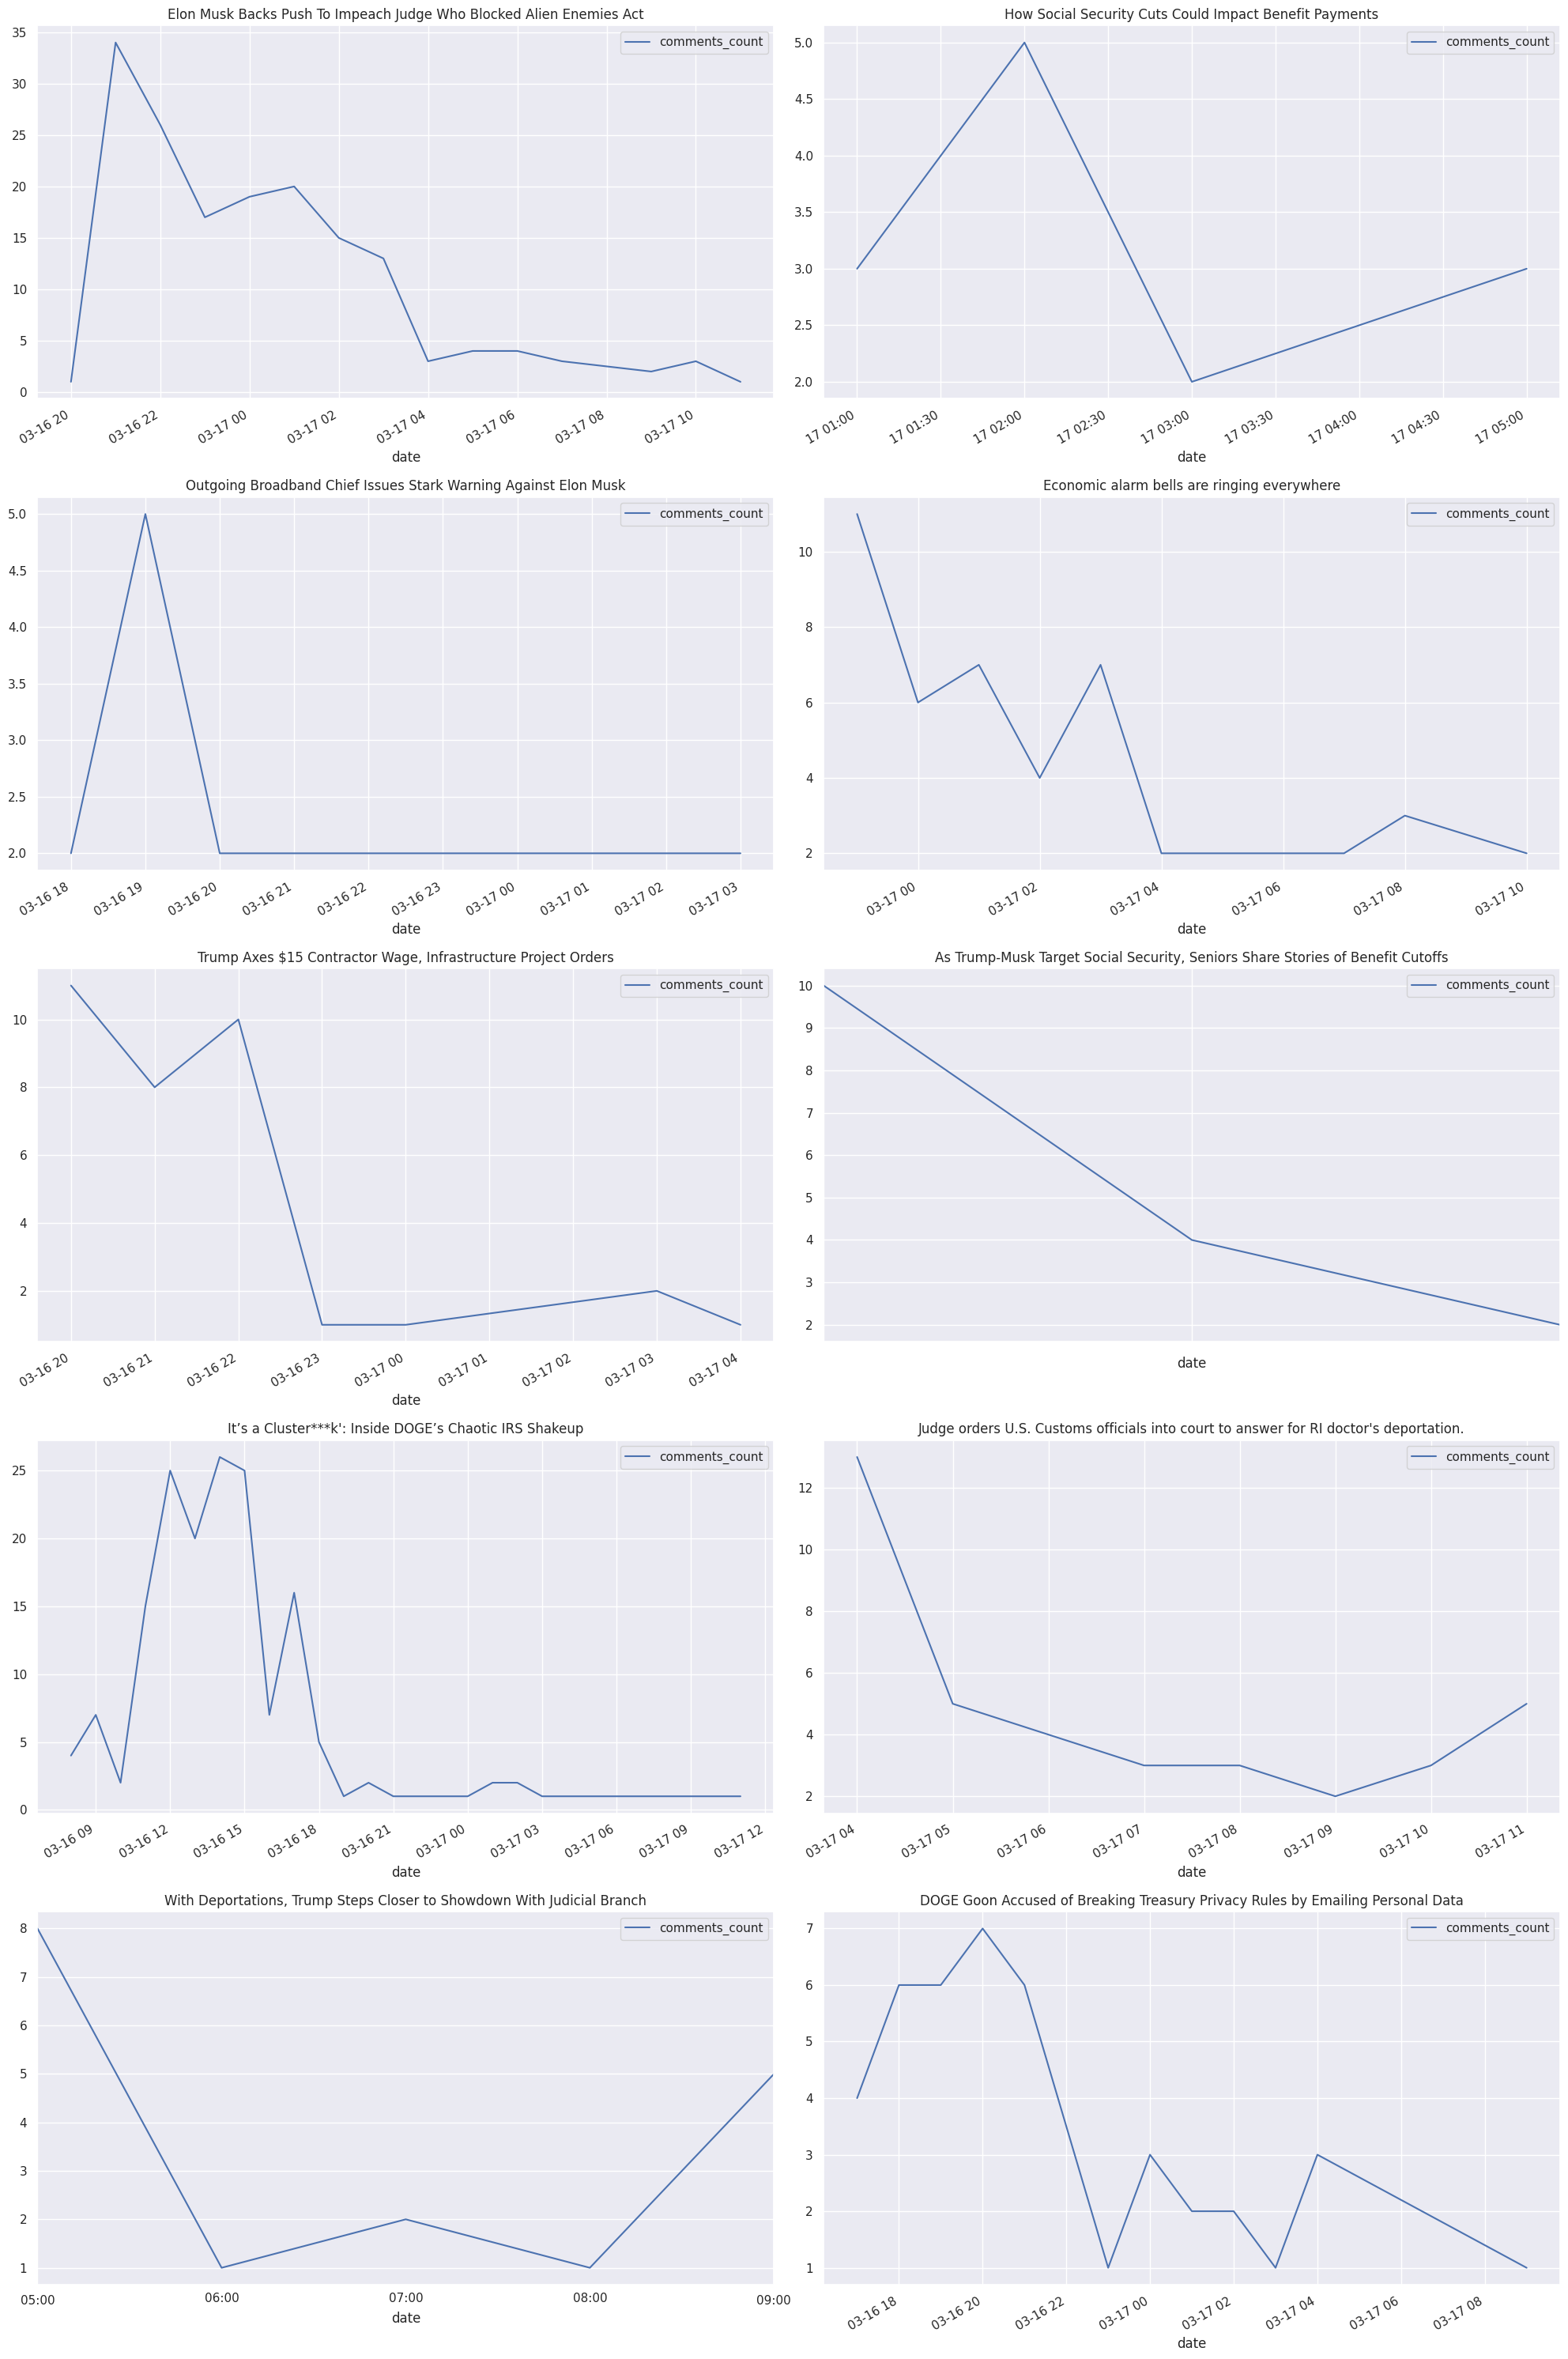

In [30]:
titles = list(set(dbdf.submission_title))[:10]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
axes = axes.flatten()

for ax, title in zip(axes, titles):
    subset = dbdf[dbdf.submission_title == title]
    subset.plot(ax=ax, title=title)

plt.tight_layout()
plt.show()

### Total submission count

<Axes: xlabel='date'>

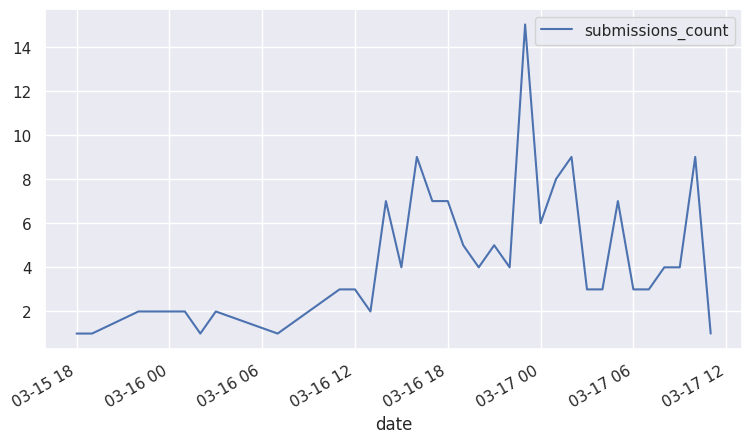

In [10]:
sph = submissions_per_hour.to_df()
sph.index = sph.date
sph = sph.drop("date", axis=1)
sph.plot(figsize=(9, 5))

### Total comments count

<Axes: xlabel='date'>

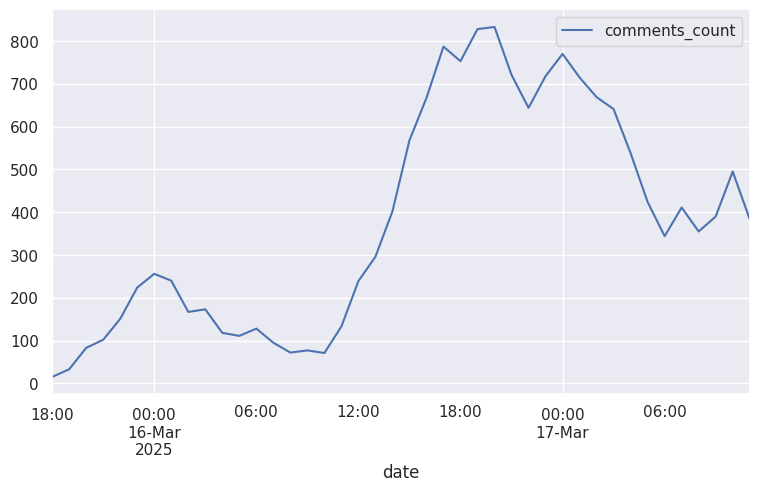

In [11]:
cph = comments_per_hour.to_df()
cph.index = cph.date
cph = cph.drop("date", axis=1)
cph.plot(figsize=(9, 5))